# Hub Analyses

This script loads files containing the z-scored node strength metrics and z-scored connectivity matrices, applies an FDR-corrected threshold to identify significant hubs, and runs additional analyses on these hubs.

## Step 1: Set up

In [1]:
# Import libraries
%matplotlib inline
from __future__ import print_function, division
import scipy, nilearn, nistats, mne, matplotlib, statsmodels
import scipy.stats as ss
import os, sys
from os.path import join as opj
import pandas as pd
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import image, plotting
import nibabel as nb
import bct
from mne.stats import fdr_correction
from nistats import thresholding
from random import shuffle

print('Done Importing Packages')

#print('bct:',bct.version)
print('matplotlib:',matplotlib.__version__)
print('mne:',mne.__version__)
print('nibabel:',nb.__version__)
print('nilearn:',nilearn.__version__)
print('nistats:',nistats.__version__)
print('numpy:',np.__version__)
print('pandas:',pd.__version__)
print('scipy:',scipy.__version__)
print('seaborn:',sns.__version__)
print('statsmodels:',statsmodels.__version__)

/Users/steventompson/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: DeprecationWarning: Python2 support is deprecated and will be removed in a future release. Consider switching to Python3.
  exec(code_obj, self.user_global_ns, self.user_ns)


Done Importing Packages
matplotlib: 2.2.2
mne: 0.16.2
nibabel: 2.3.0
nilearn: 0.4.2
nistats: 0.0.1b
numpy: 1.16.4
pandas: 0.23.0
scipy: 1.1.0
seaborn: 0.9.0
statsmodels: 0.9.0


/Users/steventompson/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .linbin import fast_linbin
/Users/steventompson/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:22: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  from .linbin import fast_linbin
/Users/steventompson/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:11: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._smoothers_lowess import lowess as _lowess
/Users/steventompson/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:11: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  from ._smoothers_lowess import lowess as _lowess
/Users/steventompson

In [2]:
# Change to directory where you saved the data
home_path = '/Users/steventompson/Git/tompson_netlearn_fmri'

data_dir = opj(home_path,'data')
template_dir = opj(data_dir,'brain_atlas')
path_zData = opj(data_dir,'ppi_zscores') # folder to put subject averages
path_Figures = opj(home_path,'figures','component_figs') # folder to put figures

# Check that all folders that you will save data in exist
for path in [path_zData, path_Figures]:
    if not os.path.exists(path):
        print('Path does not exist, creating {}'.format(path))
        os.makedirs(path)

print('Set data paths')

Set data paths


In [3]:
# Set parameters for figures
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
# Create miscellaneous functions that you will use throughout script

def conv_cfg_vec_to_adj_matr(conn_vec):
    '''
    Convert connections to adjacency matrix
    Assumes symmetric connectivity

    Parameters
    ----------
        conn_vec: numpy.ndarray
            Vector with shape (n_conn,) specifying unique connections

    Returns
    -------
        adj_matr: numpy.ndarray
            Symmetric matrix with shape (n_node, n_node)
    '''
    # Standard param checks
    #errors.check_type(conn_vec, np.ndarray)
    if not len(conn_vec.shape) == 1:
        raise ValueError('%r has more than 1-dimension')

    # Compute number of nodes
    n_node = int(np.floor(np.sqrt(2*len(conn_vec)))+1)

    # Compute upper triangle indices (by convention)
    triu_ix, triu_iy = np.triu_indices(n_node, k=1)

    # Convert to adjacency matrix
    adj_matr = np.zeros((n_node, n_node))
    adj_matr[triu_ix, triu_iy] = conn_vec

    adj_matr += adj_matr.T

    return adj_matr


def convert_adj_matr_to_cfg_matr(adj_matr):
    '''
    Convert connections to adjacency matrix
    Assumes symmetric connectivity

    Parameters
    ----------
        adj_matr: numpy.ndarray
            Matrix with shape (n_win, n_node, n_node)

    Returns
    -------
        cfg_matr: numpy.ndarray
            Symmetric matrix with shape (n_win, n_conn)
    '''
    # Standard param checks
    #errors.check_type(adj_matr, np.ndarray)
    if not len(adj_matr.shape) == 3:
        raise ValueError('%r requires 3-dimensions (n_win, n_node, n_node)')

    # Compute number of nodes
    n_node = adj_matr.shape[1]

    # Compute upper triangle indices (by convention)
    triu_ix, triu_iy = np.triu_indices(n_node, k=1)

    # Convert to configuration matrix
    cfg_matr = adj_matr[:, triu_ix, triu_iy]

    return cfg_matr

def compute_pval_twotail(test_val,null_dist,plot=False,plot_title=''):
    '''
    Compute the p-value and z-score for a test value given a null distribution

    Parameters
    ----------
        test_val: float
            numeric value to compare to null distribution
        null_dist: numpy array
            1D array of numeric values to compare with test_val
        plot: boolean
            boolean indicating whether to plot the distribution

    Returns
    -------
        zval: float
            z-score of the test_val
        pval: float
            p-value of the test_val
    '''
    pval=ss.percentileofscore(null_dist,test_val)/100
    zval=ss.norm.ppf(pval)
    if pval>0.5:
        pval=(1-pval)
    # Set zvals where p=0.00000 to an arbitrary value 
    #in this case p=.0005 and z=3.29 or -3.29, 
    #which should be greater than max value so long as len(null_dist)<2000
    if zval==-inf:
        zval=ss.norm.ppf(.0005)
    elif zval==inf:
        zval=ss.norm.ppf(.9995)
    if plot:
        plt.hist(np.append(test_val,null_dist),bins=50)
        plt.axvline(x=test_val,color='black')
        plt.text(x=np.max(null_dist)*.9,y=10,s='P-val={}'.format(pval))
        plt.title(plot_title)
        plt.show()
        plt.close()
    return zval,pval

# Step 1: Import Data

In [20]:
#load schaefer mask
schaefer_mask=nb.load('{}/schaefer400_harvard_oxford_2mm_mni_17network.nii.gz'.format(template_dir))

#load schaefer atlas info
schaefer_atlas=pd.read_pickle('{}/s400ho_ns_netLearn_2mm.pickle'.format(template_dir))

schaefer_atlas=schaefer_atlas.fillna('Uncertain')
schaefer_atlas.loc[schaefer_atlas['System']=='Uncertain','System']='Subcortical'

schaefer_atlas.loc[[402,407],'System']='Hippocampus'
schaefer_atlas.loc[[402,407],'System7']='Hippocampus'

sch_names=np.unique(schaefer_atlas['System'])
sch_nums=[int(np.where(sch_names==label)[0]) for label in schaefer_atlas['System']]


schaefer_atlas.loc[schaefer_atlas['System7']=='Uncertain','System7']='Subcortical'
sch7_names=np.unique(schaefer_atlas['System7'])
sch7_nums=[int(np.where(sch7_names==label)[0]) for label in schaefer_atlas['System7']]

net_coords=np.array(schaefer_atlas.loc[:,['x','y','z']])
net_cols=['black']*len(net_coords)

n_node = len(sch_nums)
triu_ix, triu_iy = np.triu_indices(n_node, k=1)
n_conn = len(triu_ix)

n_perm = 500

In [21]:
schaefer_atlas.head()

,nID,nVal,x,y,z,nVox,ID,Name,netNum,Hemisphere,...,attention_bi,perception_bi,reward_bi,learning_bi,motivation_bi,emotion_bi,visual_bi,workMem_bi,visual_attention_bi,visual_perception_bi
0,0,1,-35,-62,-17,309,1,17Networks_LH_VisCent_ExStr_1,17Networks,LH,...,0,1,0,0,0,0,1,0,0,0
1,1,2,-23,-73,-10,426,2,17Networks_LH_VisCent_ExStr_2,17Networks,LH,...,0,0,0,0,0,0,1,0,0,0
2,2,3,-36,-81,-16,357,3,17Networks_LH_VisCent_ExStr_3,17Networks,LH,...,0,1,0,0,0,0,1,0,0,0
3,3,4,-17,-86,-15,320,4,17Networks_LH_VisCent_ExStr_4,17Networks,LH,...,0,0,0,0,0,0,1,0,0,0
4,4,5,-24,-97,-12,531,5,17Networks_LH_VisCent_ExStr_5,17Networks,LH,...,0,0,0,0,0,0,0,0,0,0


In [7]:

list1=['combData','diffData','nonSocData','SocData']
list1_labels=['All Tasks','Social versus Non-Social','Non-Social Task','Social Task']


apriori_names=['dmPFC_L','vmPFC_L','PCC_L','Hippocampus_L','TPJ_L',
               'dmPFC_R','vmPFC_R','PCC_R','Hippocampus_R','TPJ_R',
               'Frontal_Inf_Oper_L','Frontal_Inf_Orb_L','Frontal_Inf_Tri_L',
               'Frontal_Inf_Oper_R','Frontal_Inf_Orb_R','Frontal_Inf_Tri_R',
               'Amygdala_L','Amygdala_R',
               'Ventral_Striatum_L','Caudate_L',
               'Ventral_Striatum_R','Caudate_R']


def identify_hubs1(ix,thresh=True,apriori=True,flip=False,alpha=0.05):
    '''
    Load node strength z-scores and identify hubs. This script identifies the highest node strength scores in one direction, 
    so if you want to get hubs based on a significant negative node strength, then you should set flip=True.

    Parameters
    ----------
        ix: integer 
            index for which task to load using list1
            
    Optional Inputs
    _______________
        thresh: boolean
            if thresh==True, then save the connectivity matrix as a png image
        apriori: boolean
            if apriori==True, then generate dictionary of hubs in apriori regions of interest
        flip: boolean
            if flip==True, then multiply zMat by -1 to identify strongest negative effects
        alpha: float
            decimal indicating what p-value threshold to use

    Returns
    -------
        sig_ix: numpy.ndarray
            array of integers indicating the index of the hubs in the schaefer atlas
        sig_vec: numpy.ndarray
            array of 0s and 1s with 1s indicating significant hubs
        sig_dic: dictionary
            dictionary listing the indices of hubs in each apriori ROI (which will be an empty dictionary if apriori=False)
    '''
    xx=list1[ix]
    data=np.load('{}/netLearn_{}_zscores_26subjs_nodestr.npz'.format(path_zData,xx))
    zMat=data['zMat']
    pMat=data['pMat']
    
    if flip:
        zMat=np.multiply(zMat,-1)
    
    # Set nonsignificant values to zero using FDR correction
    if thresh:
        reject_fdr,pval_fdr=fdr_correction(pMat,alpha)
        zMat=np.multiply(zMat,reject_fdr)

    title='{}- Node Strength'.format(list1_labels[ix])
    sig_ix=np.where(zMat>0)[0]
    sig_dic={}
    sig_vec=np.zeros(zMat.shape)
    if apriori:
        sig_ix=[x for x in sig_ix if schaefer_atlas.loc[x,'ns_ROI_label'] in apriori_names]
        for i,x in enumerate(apriori_names):
            sig_dic[x]=[ix for ix in sig_ix if schaefer_atlas.loc[ix,'ns_ROI_label']==x]
            sig_dic=dict((k, v) for k, v in sig_dic.iteritems() if v)

    sig_vec[sig_ix]=1
        
    print('')
    print(title)
    print('{} significant positive ROIs in a priori regions'.format(len(sig_ix)))
    return sig_ix,sig_vec,sig_dic
    
sigvals_comb,sigvec_comb,sigdic_comb=identify_hubs1(0,alpha=0.025)
signames_comb=schaefer_atlas.loc[sigvals_comb,'ns_ROI_label']

sigvals_diff,sigvec_diff,sigdic_diff=identify_hubs1(1,alpha=0.025)
signames_diff=schaefer_atlas.loc[sigvals_diff,'ns_ROI_label']


sigvals_diff_ns,sigvec_diff_ns,sigdic_diff_ns=identify_hubs1(1,flip=True,alpha=0.025)
signames_diff_ns=schaefer_atlas.loc[sigvals_diff_ns,'ns_ROI_label']

sigdic_comb['Hippocampus']=[402,407]
sigdic_comb['combhubs']=sigvals_comb
sigdic_diff['diffhubs']=sigvals_diff
sigdic_diff_ns['diffhubs_ns']=sigvals_diff_ns

lpfc_l_vals=[sigdic_diff_ns[key] for key in sigdic_diff_ns.keys() if 'Frontal' in key and '_L' in key]
sigdic_diff_ns['lPFC_L']=[item for sublist in lpfc_l_vals for item in sublist]
lpfc_r_vals=[sigdic_diff_ns[key] for key in sigdic_diff_ns.keys() if 'Frontal' in key and '_R' in key]
sigdic_diff_ns['lPFC_R']=[item for sublist in lpfc_r_vals for item in sublist]


for x in sigdic_comb.keys():
    print('Column ids for {}= {}'.format(x,sigdic_comb[x]))
    
print('')
for x in sigdic_diff.keys():
    print('Column ids for {}= {}'.format(x,sigdic_diff[x]))
    
print('')
for x in sigdic_diff_ns.keys():
    print('Column ids for {}= {}'.format(x,sigdic_diff_ns[x]))


All Tasks- Node Strength
10 significant positive ROIs in a priori regions

Social versus Non-Social- Node Strength
7 significant positive ROIs in a priori regions

Social versus Non-Social- Node Strength
11 significant positive ROIs in a priori regions
Column ids for dmPFC_L= [165, 174]
Column ids for vmPFC_L= [160]
Column ids for TPJ_R= [244]
Column ids for Hippocampus_R= [407]
Column ids for combhubs= [44, 160, 165, 174, 244, 370, 376, 378, 402, 407]
Column ids for TPJ_L= [44]
Column ids for Hippocampus_L= [402]
Column ids for Hippocampus= [402, 407]
Column ids for dmPFC_R= [370, 376, 378]

Column ids for TPJ_R= [262, 394, 396, 397]
Column ids for PCC_R= [363]
Column ids for diffhubs= [85, 172, 262, 363, 394, 396, 397]
Column ids for TPJ_L= [85, 172]

Column ids for lPFC_L= [182]
Column ids for PCC_R= [364]
Column ids for Frontal_Inf_Orb_R= [308]
Column ids for diffhubs_ns= [165, 177, 182, 304, 308, 310, 332, 364, 370, 376, 378]
Column ids for Frontal_Inf_Oper_R= [332]
Column ids fo

In [8]:
def load_cfgmat(filefolder,filename):
    '''
    loads cfg (vectorized) connectivity matrix (both z-scores and p-values) and converts to n_node x n_node connectivity matrix

    Parameters
    ----------
       filefolder: character string
            string indicating the folder where the file is located
       filename: character string
           string indicating the name of the npz file where the connectivity matrices are stored
    
    Returns
    -------
        zMat_1: numpy array
            2D n_nodes x n_nodes numpy array of z-scores
            or 3D n_subj x n_nodes x n_nodes numpy array of z-scores
        pMat_1: numpy array
            2D n_nodes x n_nodes numpy array of p-values
            or 3D n_subj x n_nodes x n_nodes numpy array of p-values
    '''
    data_1=np.load(opj(filefolder,filename))
    if len(data_1['zMat'].shape)>1:
        zMat_1=np.array([conv_cfg_vec_to_adj_matr(data_1['zMat'][x,:]) for x in range(data_1['zMat'].shape[0])])
        pMat_1=np.array([conv_cfg_vec_to_adj_matr(data_1['pMat'][x,:]) for x in range(data_1['pMat'].shape[0])])
    else:
        zMat_1=conv_cfg_vec_to_adj_matr(data_1['zMat'])
        pMat_1=conv_cfg_vec_to_adj_matr(data_1['pMat'])
    return zMat_1,pMat_1


# Load group-level z-scored connectivity matrices
diff_zMat_g,diff_pMat_g=load_cfgmat(path_zData,'netLearn_diffData_zscores_groupavg_410nodes_connmat.npz')
comb_zMat_g,comb_pMat_g=load_cfgmat(path_zData,'netLearn_combData_zscores_groupavg_410nodes_connmat.npz')

# Figure 2A: Connectivity Matrix for Transition vs. Non-Transition Contrast

In [9]:
# Plot connectivity matrix
def plot_connMat(myarray,sys_numbers,sys_names,pvals=None,thresh=False,alpha=0.05,filt=False,
                 save=False,figName='test',cmap='RdBu_r',vrange='SDplot',figtype='svg'):
    '''
    Plots connectivity matrix and sorts by system
    Assumes symmetric connectivity

    Parameters
    ----------
       myarray: numpy.ndarray
            matrix with shape (n_nodes,n_nodes) specifying pairwise connectivity between edges
            or
            matrix with shape (n_conn,) representing the vector of unique edges
       sys_numbers: numpy.ndarray
            vector with shape (n_nodes,) specifying system assignments for each node
        sys_names: numpy.ndarray
            vector with shape (n_nodes,) specifying names of systems. Must match order of sys_numbers
    
    Optional Inputs
    _______________
        save: boolean
            if save==True, then save the connectivity matrix as a png image
        figName: character string
            if save==True, save the file in the path_Figures folder with figName   
        cmap: character string
            defaults to red blue range see matplotlib cmaps for options
        vrange: tuple or character string
            default is 'SDplot' which sets the vmin and vmax to +/- 3 standard deviations from 0
            can also manually set with tuple e.g. (-1,1)
        
    '''
    
    bounds,ixes=bct.grid_communities(sys_numbers.astype('int'))       
    fig, ax1 = plt.subplots(1, 1, figsize=(10,8), facecolor='white')
    #fig.suptitle('Connectivity during Go/No-Go task', fontsize=24)
    if len(vrange)==2:
        vmin=min(vrange)
        vmax=max(vrange)
    else:
        vmin=-(3*np.std(myarray))
        vmax = (3*np.std(myarray))

    # Set zvals where p=0.00000 to an arbitrary value 
    #in this case p=.0005 and z=3.29 or -3.29, 
    #which should be greater than max value so long as len(null_dist)<2000
    myarray[myarray==inf]=ss.norm.ppf(.9995)
    myarray[myarray==-inf]=ss.norm.ppf(.0005)

    #Convert the arbitrarily set values for p=0 (where z=inf or -inf) from 4 to 
    #a less arbitrary z=3.29 or z=-3.29
    #which should be greater than max value so long as len(null_dist)<2000
    myarray[myarray==4]=ss.norm.ppf(.9995)
    myarray[myarray==-4]=ss.norm.ppf(.0005)
    
    if thresh:
        reject_fdr,pval_fdr=fdr_correction(pvals,alpha)
        zMat=conv_cfg_vec_to_adj_matr(np.multiply(myarray,reject_fdr))
    else:
        zMat=conv_cfg_vec_to_adj_matr(myarray)
    if filt=='Pos':
        zMat[zMat<0]=0
    elif filt=='Neg':
        zMat[zMat>0]=0
        
    im= ax1.imshow(zMat[np.ix_(ixes,ixes)],interpolation='none',cmap=cmap, vmin = vmin, vmax = vmax);
    #for b in bounds:
    #      ax1.axvline(x=b,color='red')
    #      ax1.axhline(y=b,color='red')
    
    bounds1=np.hstack((np.array(0.5),bounds))
    bticks=np.zeros(len(bounds))
    for ix,xx in enumerate(bounds):
        bticks[ix]=(bounds1[ix+1]+bounds1[ix])/2
    
    ax1.grid(False);
    plt.xticks(bticks,sys_names)
    plt.yticks(bticks,sys_names)
    ax1.tick_params(axis='both', labelsize=16)
    #for item in ax1.get_yticklabels():
    #    item.set_rotation(20)
    for item in ax1.get_xticklabels():
        item.set_rotation(90)
    cbar = plt.colorbar(im, ax = ax1, shrink = 0.7)
    cbar.ax.tick_params(labelsize=16) 
    #ax1.set_title(figTitle)
    plt.tight_layout()
    if save:
        plt.savefig('{}/{}.{}'.format(path_Figures,figName,figtype))

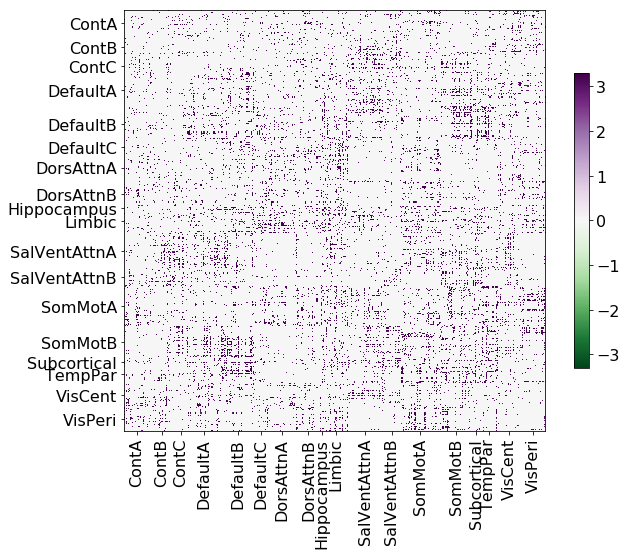

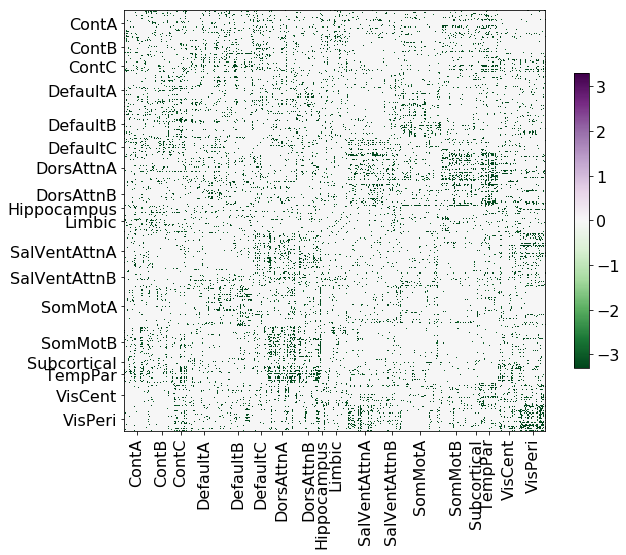

In [10]:


plot_connMat(myarray=convert_adj_matr_to_cfg_matr(np.expand_dims(comb_zMat_g,axis=0)).squeeze(),
             pvals=convert_adj_matr_to_cfg_matr(np.expand_dims(comb_pMat_g,axis=0)).squeeze(),
             filt='Pos',thresh=True,alpha=0.025,save=True,figName='fig2a_pos',
             sys_numbers=np.array(sch_nums),sys_names=np.array(sch_names),
             vrange=[-3.3,3.3],cmap='PRGn_r')

plot_connMat(myarray=convert_adj_matr_to_cfg_matr(np.expand_dims(comb_zMat_g,axis=0)).squeeze(),
             pvals=convert_adj_matr_to_cfg_matr(np.expand_dims(comb_pMat_g,axis=0)).squeeze(),
             filt='Neg',thresh=True,alpha=0.025,save=True,figName='fig2a_neg',
             sys_numbers=np.array(sch_nums),sys_names=np.array(sch_names),
             vrange=[-3.3,3.3],cmap='PRGn_r')

# Figure 3A: Connectivity Matrix for Social vs. Non-Social Contrast

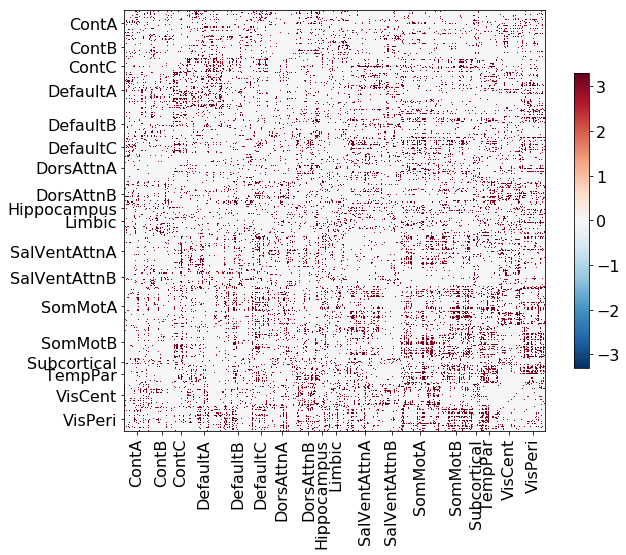

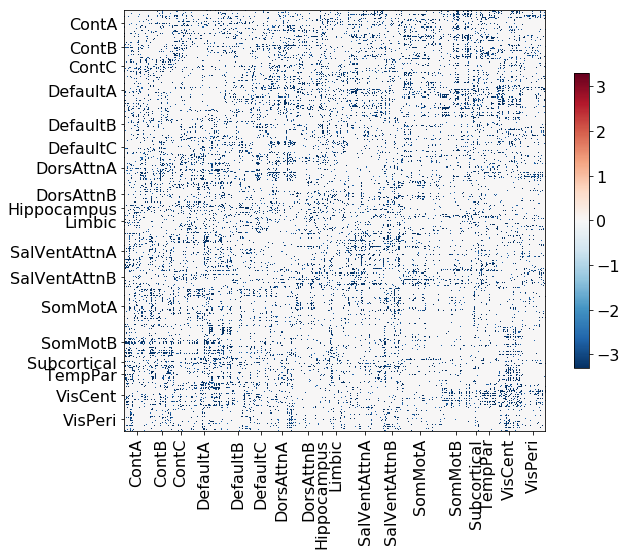

In [11]:
plot_connMat(myarray=convert_adj_matr_to_cfg_matr(np.expand_dims(diff_zMat_g,axis=0)).squeeze(),
             pvals=convert_adj_matr_to_cfg_matr(np.expand_dims(diff_pMat_g,axis=0)).squeeze(),
             filt='Pos',thresh=True,alpha=0.025,save=True,figName='fig3a_pos',
             sys_numbers=np.array(sch_nums),sys_names=np.array(sch_names),
             vrange=[-3.3,3.3],cmap='RdBu_r')

plot_connMat(myarray=convert_adj_matr_to_cfg_matr(np.expand_dims(diff_zMat_g,axis=0)).squeeze(),
             pvals=convert_adj_matr_to_cfg_matr(np.expand_dims(diff_pMat_g,axis=0)).squeeze(),
             filt='Neg',thresh=True,alpha=0.025,save=True,figName='fig3a_neg',
             sys_numbers=np.array(sch_nums),sys_names=np.array(sch_names),
             vrange=[-3.3,3.3],cmap='RdBu_r')

# Figure 2B: Node Strength Brain Maps for Transition vs. Non-Transition Contrast

In [12]:
roi_names=['dmPFC_L','vmPFC_L','PCC_L','Hippocampus_L','TPJ_L','Hippocampus',
           'dmPFC_R','vmPFC_R','PCC_R','Hippocampus_R','TPJ_R',
           'lPFC_L','Amygdala_L','Ventral_Striatum_L','Caudate_L',
           'lPFC_R','Amygdala_R','Ventral_Striatum_R','Caudate_R']
    
roi_names=sorted(roi_names, key=lambda s: s.lower())

In [13]:
def plot_roi_means(row_means,mask,maskindex,thresh=0,cut_coords=5,figTitle='',colormap='RdBu_r',dmode='x'):
    '''
    Plots values for each node onto nii brain image

    Parameters
    ----------
       row_means: numpy array
            matrix with shape (n_nodes,) specifying values for each node
       mask: character string
           string indicating the nii file with mask values for each node
        maskindex: list or numpy array
            list of values linking each row in row_means to each value in the nii mask
            
    Optional Inputs
    _______________
        thresh: float
            value to threshold the row_means
        cut_coords: integer or tuple
            single value if dmode is a single letter, tuple if multiple cuts required. value indicates the coordinates to view the brain
        figTitle: character string
            string to add to the figure
        colormap: character string
            string indicating which colormap to use
        dmode: character string
            string indicating which axes to present brain images for
    
    Returns
    ________________
        display: nilearn plotting object
            stat_map from the nilearn plotting.plot_stat_map() function

    '''    
    #Get mask data and create blank mask to fill with values
    mdata=mask.get_data()
    img=np.zeros(mdata.shape)
    
    #next, loop over maskindex to assign roi means to voxels in brain mask
    for x in range(len(row_means)):
        roiVal=row_means[x]
        mval=maskindex[x]
        if np.absolute(roiVal)>thresh:
            img[mdata==mval]=roiVal
    
    #Convert mask array to nifti-like image
    mimg=nb.Nifti1Image(img,mask.affine)
    
    #Plot image
    display=plotting.plot_stat_map(mimg, title=figTitle,
                           display_mode=dmode,cut_coords=cut_coords,
                           cmap=colormap,colorbar=True)
    return display


def comb_plot(thresh=False,alpha=0.05,figtype='svg'):
    '''
    Plot brain image of node strength scores
            
    Optional Inputs
    _______________
        thresh: boolean
            if thresh==True, then only display values for nodes that had significant node strength scores
        alpha: float
            decimal indicating what p-value threshold to use
        figtype: character string
            what format to save the image as
    '''
    roidict={}
    roidf=pd.DataFrame(index=apriori_names)
    for iy,yy in enumerate(list1):
        data=np.load('{}/netLearn_{}_zscores_26subjs_nodestr.npz'.format(path_zData,yy))
        zMat=data['zMat']
        pMat=data['pMat']
        
        # Set zvals where p=0.00000 to an arbitrary value 
        #in this case p=.0005 and z=3.29 or -3.29, 
        #which should be greater than max value so long as len(null_dist)<2000
        zMat[zMat==inf]=ss.norm.ppf(.9995)
        zMat[zMat==-inf]=ss.norm.ppf(.0005)

        #Convert the arbitrarily set values for p=0 (where z=inf or -inf) from 4 to 
        #a less arbitrary z=3.29 or z=-3.29
        #which should be greater than max value so long as len(null_dist)<2000
        zMat[zMat==4]=ss.norm.ppf(.9995)
        zMat[zMat==-4]=ss.norm.ppf(.0005)

        if thresh:
            reject_fdr,pval_fdr=fdr_correction(pMat,alpha)
            zMat=np.multiply(zMat,reject_fdr)
        
        if yy=='diffData':
            zMat_pos=zMat.copy()
            zMat_pos[zMat_pos<0]=0
            title='Social versus Non-Social- Node Strength'
            d1=plot_roi_means(row_means=zMat_pos,
                   mask=schaefer_mask,maskindex=schaefer_atlas['nVal'],dmode='x',
                   cut_coords=[-55,-50,-25,-10,-5],figTitle=title,colormap='RdBu_r')
            d2=plot_roi_means(row_means=zMat_pos,
                   mask=schaefer_mask,maskindex=schaefer_atlas['nVal'],dmode='x',
                   cut_coords=[5,10,25,50,55],colormap='RdBu_r')
            d1.savefig('{}/{}_all_soc_lh.{}'.format(path_Figures,yy,figtype))
            d2.savefig('{}/{}_all_soc_rh.{}'.format(path_Figures,yy,figtype))
            
            zMat_neg=zMat.copy()
            zMat_neg[zMat_neg>0]=0
            title='Non-Social versus Social- Node Strength'
            d1=plot_roi_means(row_means=zMat_neg,
                   mask=schaefer_mask,maskindex=schaefer_atlas['nVal'],dmode='x',
                   cut_coords=[-55,-50,-25,-10,-5],figTitle=title,colormap='RdBu_r')
            d2=plot_roi_means(row_means=zMat_neg,
                   mask=schaefer_mask,maskindex=schaefer_atlas['nVal'],dmode='x',
                   cut_coords=[5,10,25,50,55],colormap='RdBu_r')
            d1.savefig('{}/{}_all_ns_lh.{}'.format(path_Figures,yy,figtype))
            d2.savefig('{}/{}_all_ns_rh.{}'.format(path_Figures,yy,figtype))
        else:
            title='{}- Node Strength'.format(list1_labels[iy])
            d1=plot_roi_means(row_means=zMat,
                   mask=schaefer_mask,maskindex=schaefer_atlas['nVal'],dmode='x',
                   cut_coords=[-55,-50,-25,-10,-5],figTitle=title,colormap='PRGn_r')
            d2=plot_roi_means(row_means=zMat,
                   mask=schaefer_mask,maskindex=schaefer_atlas['nVal'],dmode='x',
                   cut_coords=[5,10,25,50,55],colormap='PRGn_r')
            d1.savefig('{}/{}_all_lh.{}'.format(path_Figures,yy,figtype))
            d2.savefig('{}/{}_all_rh.{}'.format(path_Figures,yy,figtype))

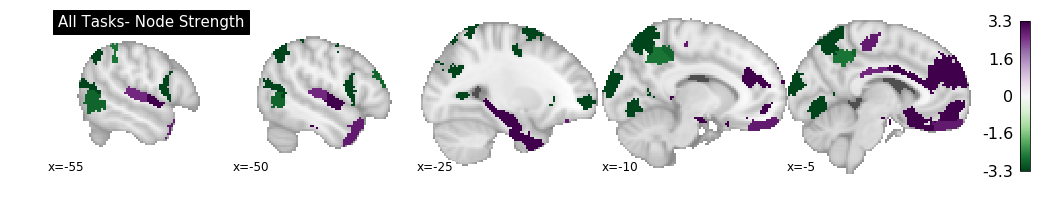

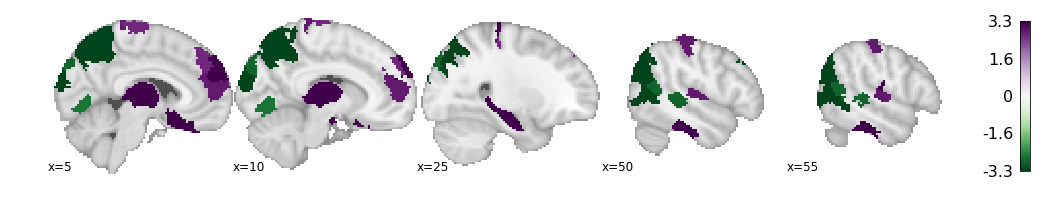

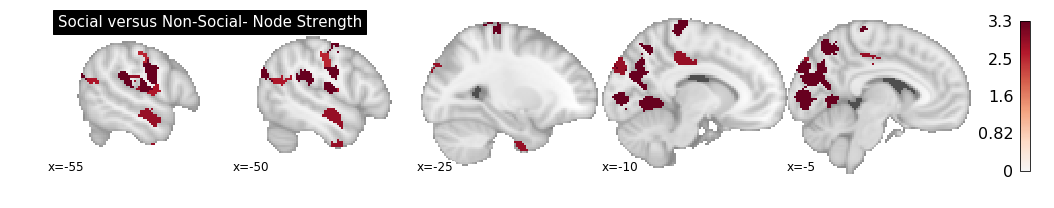

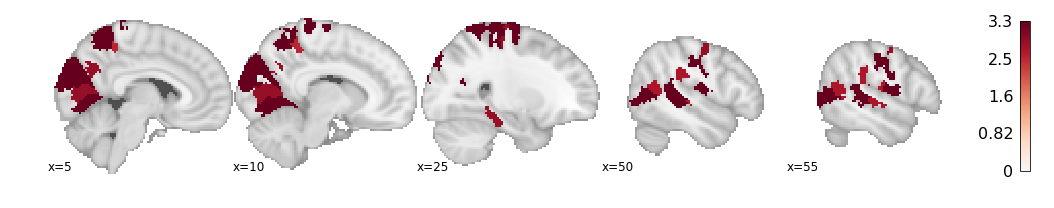

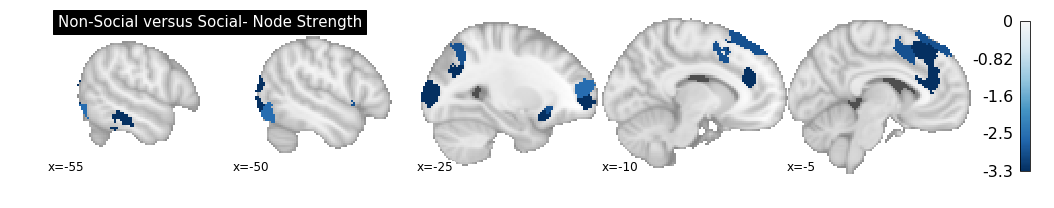

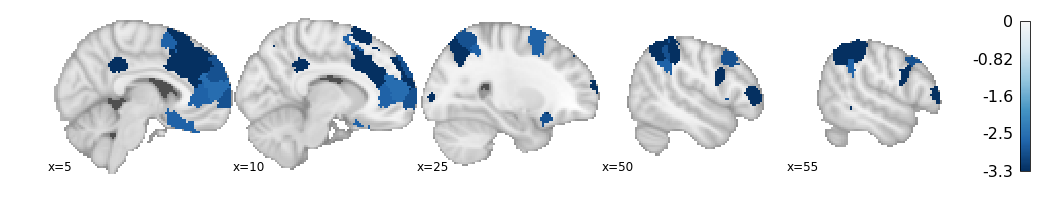

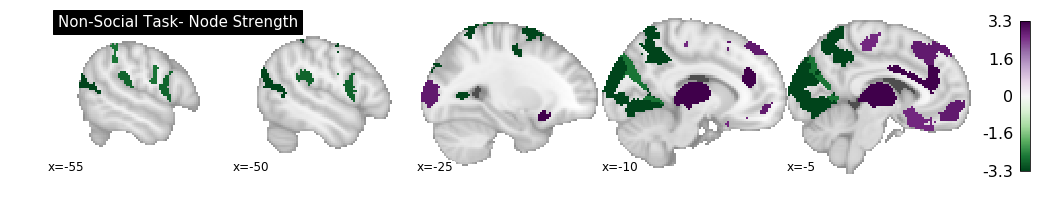

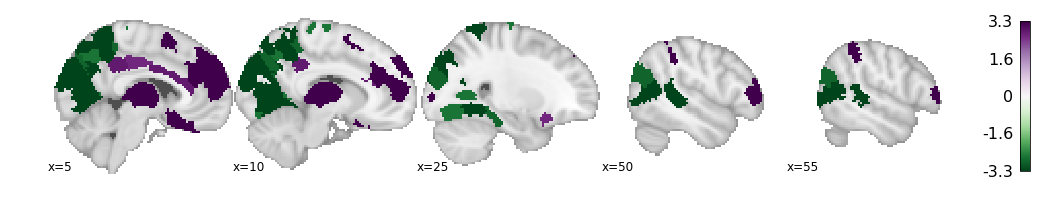

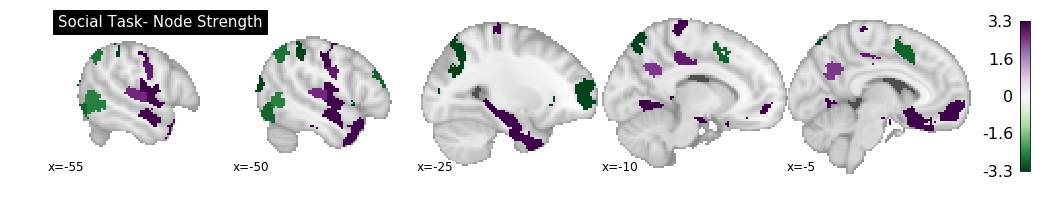

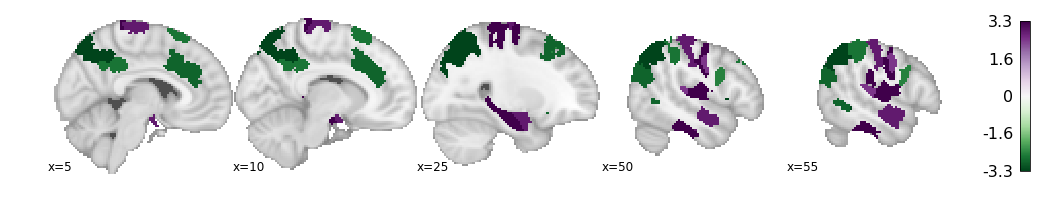

In [14]:
comb_plot(thresh=True,alpha=0.025)

# Figure 2C: System percentages for transition versus non-transition contrast

In [15]:
def count_hubs(sig_ix,sys_list):
    '''
    Count the number of hubs in each system

    Parameters
    ----------
        sig_ix: list or numpy array
            list of integer indices for hubs
        sys_list: list of length n_nodes
            list of system labels for each node
    
    Returns
    ________________
        hcount: list
            list of the number hubs in each system
    '''
    
    cog_sys_names=np.unique(sys_list)
    hcount=[np.sum(np.where(sys_list[sig_ix]==cname,1,0)) for cname in cog_sys_names]
    return hcount

def hub_sys_test(atlas_df,sig_ix,system_column,n_perm=500):
    '''
    shuffle the system labels for all the nodes and run permutation test for the number of hubs in each system

    Parameters
    ----------
        atlas_df: pandas dataframe
            dataframe containing information about the system labels for each node
        sig_ix: list or numpy array of integers
            integer list indicating the indices for each hub
        system_column: character string
            string indicating which column of the atlas_df contains the system labels to analyze
            
    Optional Inputs
    _______________
        n_perm: integer
            how many times to shuffle the system labels
    
    Returns
    ________________
        sys_dict: dictionary
            dictionary containing counts, percentages, z-scores, and p-values for each system
    '''
    cog_sys_names=np.unique(atlas_df[system_column])
    
    #Get count of number of hubs in each system
    hcount=count_hubs(sig_ix,atlas_df[system_column])
    n_nodes=len(atlas_df)
    sys_size=count_hubs(range(n_nodes),atlas_df[system_column])
    hpercent=np.divide(hcount,sys_size,dtype='float')
    
    perm_labels=atlas_df[system_column].values.copy()
    hcount_null=np.zeros((len(hcount),n_perm))
    hpercent_null=np.zeros((len(hpercent),n_perm))
    for pp in range(n_perm):
        shuffle(perm_labels)
        hcount_null[:,pp]=count_hubs(sig_ix,perm_labels)
        hpercent_null[:,pp]=np.divide(count_hubs(sig_ix,perm_labels),sys_size,dtype='float')
    
    zvals1=np.zeros(len(cog_sys_names))
    zvals2=np.zeros(len(cog_sys_names))
    pvals1=np.ones(len(cog_sys_names))
    pvals2=np.ones(len(cog_sys_names))
    for sys in range(len(hcount)):
        zvals1[sys],pvals1[sys]=compute_pval_twotail(hcount[sys],hcount_null[sys,:])
        zvals2[sys],pvals2[sys]=compute_pval_twotail(hpercent[sys],hpercent_null[sys,:])
        
    sys_dict={'hub_count':hcount,'hub_percent':hpercent,
            'zvals_count':zvals1,'zvals_percent':zvals2,
            'pvals_count':pvals1,'pvals_percent':pvals2,
             'null_count':hcount_null,'null_percent':hpercent_null}
    return sys_dict
        
def loop_hub_sys_test(atlas_df,system_column,n_perm=500):
    '''
    run the hub system permutation testing for each set of hubs and add to pandas dataframe

    Parameters
    ----------
        atlas_df: pandas dataframe
            dataframe containing information about the system labels for each node
        system_column: character string
            string indicating which column of the atlas_df contains the system labels to analyze
            
    Optional Inputs
    _______________
        n_perm: integer
            how many times to shuffle the system labels
    
    Returns
    ________________
        sys_df: pandas dataframe
            dataframe containing results of hub_sys_test
        null_dict: dictionary
            dictionary containing shuffled hub counts (null models) for each system
    '''
    #Create dataframe to fill with system counts
    cog_sys_names=np.unique(atlas_df[system_column])

    comb_dict=hub_sys_test(atlas_df,sigvals_comb_all,system_column,n_perm)
    comb_neg_dict=hub_sys_test(atlas_df,sigvals_comb_neg_all,system_column,n_perm)
    soc_dict=hub_sys_test(atlas_df,sigvals_soc_all,system_column,n_perm)
    ns_dict=hub_sys_test(atlas_df,sigvals_ns_all,system_column,n_perm)    
    
    n_nodes=len(atlas_df)
    sys_size=count_hubs(range(n_nodes),atlas_df[system_column])
    
    sys_df=pd.DataFrame(cog_sys_names,columns=['System'])
    sys_df['Sys_Size']=sys_size
    sys_df['Comb_Count']=comb_dict['hub_count']
    sys_df['Comb_Neg_Count']=comb_neg_dict['hub_count']
    sys_df['Soc_Count']=soc_dict['hub_count']
    sys_df['NS_Count']=ns_dict['hub_count']
    sys_df['Comb_Percent']=comb_dict['hub_percent']
    sys_df['Comb_Neg_Percent']=comb_neg_dict['hub_percent']
    sys_df['Soc_Percent']=soc_dict['hub_percent']
    sys_df['NS_Percent']=ns_dict['hub_percent']
    
    sys_df['Comb_Count_zvals']=comb_dict['zvals_count']
    sys_df['Comb_Neg_Count_zvals']=comb_neg_dict['zvals_count']
    sys_df['Soc_Count_zvals']=soc_dict['zvals_count']
    sys_df['NS_Count_zvals']=ns_dict['zvals_count']
    sys_df['Comb_Percent_zvals']=comb_dict['zvals_percent']
    sys_df['Comb_Neg_Percent_zvals']=comb_neg_dict['zvals_percent']
    sys_df['Soc_Percent_zvals']=soc_dict['zvals_percent']
    sys_df['NS_Percent_zvals']=ns_dict['zvals_percent']
    
    sys_df['Comb_Count_pvals']=comb_dict['pvals_count']
    sys_df['Comb_Neg_Count_pvals']=comb_neg_dict['pvals_count']
    sys_df['Soc_Count_pvals']=soc_dict['pvals_count']
    sys_df['NS_Count_pvals']=ns_dict['pvals_count']
    sys_df['Comb_Percent_pvals']=comb_dict['pvals_percent']
    sys_df['Comb_Neg_Percent_pvals']=comb_neg_dict['pvals_percent']
    sys_df['Soc_Percent_pvals']=soc_dict['pvals_percent']
    sys_df['NS_Percent_pvals']=ns_dict['pvals_percent'] 
    
    sys_df['Soc_vs_NS_Count']=np.array(soc_dict['hub_count'])-np.array(ns_dict['hub_count'])
    sys_df['Soc_vs_NS_Percent']=np.array(soc_dict['hub_percent'])-np.array(ns_dict['hub_percent'])
    
    diff_null_count=np.array(soc_dict['null_count'])-np.array(ns_dict['null_count'])
    diff_null_percent=np.array(soc_dict['null_percent'])-np.array(ns_dict['null_percent'])

    sys_df['Soc_vs_NS_Count_zvals']=0
    sys_df['Soc_vs_NS_Count_pvals']=0
    
    sys_df['Soc_vs_NS_Percent_zvals']=0
    sys_df['Soc_vs_NS_Percent_pvals']=0
    
    for nn,name in enumerate(cog_sys_names):    
        zval1,pval1=compute_pval_twotail(sys_df.loc[nn,'Soc_vs_NS_Count'],diff_null_count[nn,:])
        zval2,pval2=compute_pval_twotail(sys_df.loc[nn,'Soc_vs_NS_Percent'],diff_null_percent[nn,:])
        sys_df.loc[nn,'Soc_vs_NS_Count_zvals']=zval1
        sys_df.loc[nn,'Soc_vs_NS_Count_pvals']=pval1
        sys_df.loc[nn,'Soc_vs_NS_Percent_zvals']=zval2
        sys_df.loc[nn,'Soc_vs_NS_Percent_pvals']=pval2


    null_dict={'comb_null_count':comb_dict['null_count'],'comb_null_percent':comb_dict['null_percent'],
               'comb_neg_null_count':comb_neg_dict['null_count'],'comb_neg_null_percent':comb_neg_dict['null_percent'],
               'soc_null_count':soc_dict['null_count'],'soc_null_percent':soc_dict['null_percent'],
               'ns_null_count':ns_dict['null_count'],'ns_null_percent':ns_dict['null_percent'],
               'diff_null_count':diff_null_count,'diff_null_percent':diff_null_percent}
              
    return sys_df,null_dict





In [27]:
def load_zscores(filename,thresh=False,alpha=0.05):
    '''
    Load a zscore connectivity matrix

    Parameters
    ----------
        xx: character string
            string indicating which task to load data for
        yy: character string
            string indicating which connectivity z-scores to load

    Returns
    -------
        zMat: numpy array
            1D n_nodes numpy array of z-scores
            or 2D n_nodes x n_nodes numpy array of z-scores
        pMat: numpy array
            1D n_nodes numpy array of p-values
            or 2D n_nodes x n_nodes numpy array of p-values
    '''
    data=np.load(opj(path_zData,filename))
    zMat=data['zMat']
    pMat=data['pMat']
    if thresh:
        if len(pMat.shape)>1:
            pVec=convert_adj_matr_to_cfg_matr(np.expand_dims(pMat,axis=0)).squeeze()
            reject_fdr,pval_fdr=fdr_correction(pVec,alpha)
            reject_fdr_mat=conv_cfg_vec_to_adj_matr(reject_fdr)
            zMat=np.multiply(zMat,reject_fdr_mat)
        else:
            reject_fdr,pval_fdr=fdr_correction(pMat,alpha)
            zMat=np.multiply(zMat,reject_fdr)   
    return zMat,pMat


def get_hubs(xx,thresh=True,apriori=True,flip=False,alpha=0.025):
    '''
    Identify hubs given a set of z-scores and p-values for connectivity

    Parameters
    ----------
        xx: character string
            string indicating which task to load data for
        atlas: pandas dataframe
            2D pandas df with atlas information (node ids and labels)
        atlas_labels: character string
            string indicating which column in atlas to use for roi names
        roi_names: list
            list indicating which rois to consider for significant test
        title: character string
            title to include in printing results
        thresh: boolean
            boolean indicating whether to apply FDR correction
            if True, also need to set alpha (default=0.05)
        apriori: boolean
            boolean indicating whether to only include 
        flip:
            boolean indicating whether to flip the z-scores 
            which would identify hubs with sig negative z-scores
        alpha: float
            numeric value indicating the p-value threshold to apply to FDR correction

    Returns
    -------
        sig_ix: list
            output description
        sig_vec: numpy array
            1D n_nodes array where 0 indicates a non-hub and 1 indicates a significant hub
        sig_dic: dictionary
            dictionary with keys indicating the indices for significant hubs for each ROI
    '''
    filename='netLearn_{}_zscores_26subjs_nodestr.npz'.format(xx)
    zMat,pMat=load_zscores(filename)
    sigvals,sigvec,sigdic=identify_hubs2(pMat,zMat,schaefer_atlas,'ns_ROI_label',apriori_names,
                                        title='Significant Hubs for {}'.format(xx),
                                        thresh=thresh,apriori=apriori,flip=flip,alpha=alpha)
    return sigvals,sigvec,sigdic

def identify_hubs2(pMat,zMat,atlas,atlas_labels,roi_names,title='Significant Hubs',
                  thresh=True,apriori=True,flip=False,alpha=0.05):
    '''
    Identify hubs given a set of z-scores and p-values for connectivity

    Parameters
    ----------
        zMat: numpy array
            1D n_nodes numpy array of z-scores
        pMat: numpy array
            1D n_nodes numpy array of p-values
        atlas: pandas dataframe
            2D pandas df with atlas information (node ids and labels)
        atlas_labels: character string
            string indicating which column in atlas to use for roi names
        roi_names: list
            list indicating which rois to consider for significant test
        title: character string
            title to include in printing results
        thresh: boolean
            boolean indicating whether to apply FDR correction
            if True, also need to set alpha (default=0.05)
        apriori: boolean
            boolean indicating whether to only include 
        flip:
            boolean indicating whether to flip the z-scores 
            which would identify hubs with sig negative z-scores
        alpha: float
            numeric value indicating the p-value threshold to apply to FDR correction

    Returns
    -------
        sig_ix: list
            output description
        sig_vec: numpy array
            1D n_nodes array where 0 indicates a non-hub and 1 indicates a significant hub
        sig_dic: dictionary
            dictionary with keys indicating the indices for significant hubs for each ROI
    '''
    if flip:
        zMat=np.multiply(zMat,-1)
        
    if thresh:
        reject_fdr,pval_fdr=fdr_correction(pMat,alpha)
        zMat=np.multiply(zMat,reject_fdr)

    sig_ix=np.where(zMat>0)[0]
    sig_dic={}
    sig_vec=np.zeros(zMat.shape)
    if apriori:
        sig_ix=[x for x in sig_ix if atlas.loc[x,atlas_labels] in roi_names]
        for i,x in enumerate(roi_names):
            sig_dic[x]=[ix for ix in sig_ix if atlas.loc[ix,atlas_labels]==x]
            sig_dic=dict((k, v) for k, v in sig_dic.iteritems() if v)
    else:
        sig_rois=np.unique([schaefer_atlas.loc[ix,] for ix in sig_ix])
        for i,x in enumerate(sig_rois):
            sig_dic[x]=[ix for ix in sig_ix if atlas.loc[ix,atlas_labels]==x]
            sig_dic=dict((k, v) for k, v in sig_dic.iteritems() if v)
    sig_vec[sig_ix]=1
        
    print('')
    print(title)
    print('{} significant positive ROIs in a priori regions'.format(len(sig_ix)))
    return sig_ix,sig_vec,sig_dic

In [28]:
sigvals_comb_all,sigvec_comb_all,sigdic_comb_all=get_hubs('combData',thresh=True,apriori=False,flip=False,alpha=0.025)
signames_comb_all=schaefer_atlas.loc[sigvals_comb_all,'ns_ROI_label']

sigvals_comb_neg_all,sigvec_comb_neg_all,sigdic_comb_neg_all=get_hubs('combData',thresh=True,apriori=False,flip=True,alpha=0.025)
signames_comb_neg_all=schaefer_atlas.loc[sigvals_comb_neg_all,'ns_ROI_label']

sigvals_soc_all,sigvec_soc_all,sigdic_soc_all=get_hubs('diffData',thresh=True,apriori=False,flip=False,alpha=0.025)
signames_soc_all=schaefer_atlas.loc[sigvals_soc_all,'ns_ROI_label']

sigvals_ns_all,sigvec_ns_all,sigdic_ns_all=get_hubs('diffData',thresh=True,apriori=False,flip=True,alpha=0.025)
signames_ns_all=schaefer_atlas.loc[sigvals_ns_all,'ns_ROI_label']

/Users/steventompson/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:312: DeprecationWarning: unorderable dtypes; returning scalar but in the future this will be an error
  ar.sort()



Significant Hubs for combData
36 significant positive ROIs in a priori regions

Significant Hubs for combData
49 significant positive ROIs in a priori regions

Significant Hubs for diffData
63 significant positive ROIs in a priori regions

Significant Hubs for diffData
55 significant positive ROIs in a priori regions


In [18]:
df1,dict1=loop_hub_sys_test(schaefer_atlas,'System')

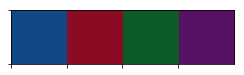

In [19]:
# Set up figure formatting
custom_palette=[(0.071280276816609, 0.2878892733564014, 0.518800461361015),#Blue
                (0.5423298731257209, 0.044290657439446365, 0.1437139561707036),#Red
                (0.045674740484429065, 0.35463283352556707, 0.1532487504805844),#Green
                (0.3423298731257211, 0.07104959630911206, 0.3888504421376396)]#Purple

sns.palplot(custom_palette)

sys_labels=['Control A','Control B','Control C',
            'Default A','Default B','Default C',
            'Dorsal Attention A','Dorsal Attention B',
            'Hippocampus','Limbic',
            'Ventral Attention A','Ventral Attention B',
            'Somatomotor A','Somatomotor B',
            'Subcortical','Temporoparietal',
            'Central Visual','Peripheral Visual']

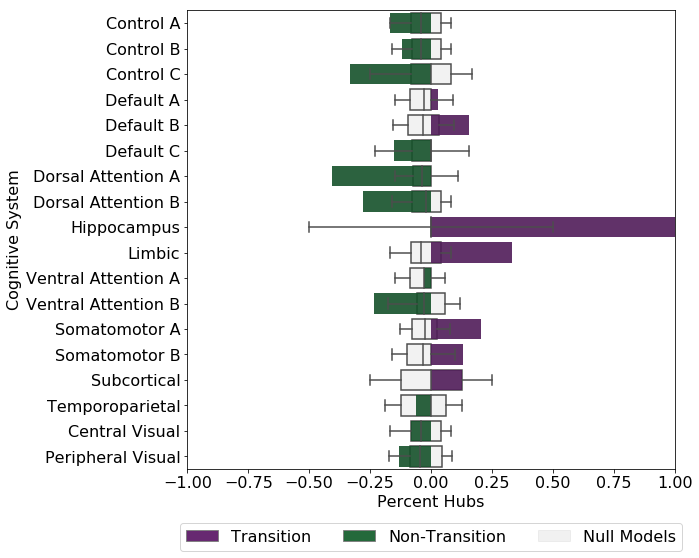

In [20]:
comb_diff_null_df=pd.DataFrame(dict1['comb_null_percent'].T,columns=sys_labels)-pd.DataFrame(dict1['comb_neg_null_percent'].T,columns=sys_labels)

comb_diff=df1['Comb_Percent'].values.copy()-df1['Comb_Neg_Percent'].values.copy()
pos_diff=comb_diff.copy()
neg_diff=comb_diff.copy()
pos_diff[pos_diff<0]=0
neg_diff[neg_diff>0]=0

fig, ax = plt.subplots(figsize=(10,8))
l1=sns.barplot(x='value',y='variable',
            data=pd.DataFrame(zip(pos_diff,sys_labels),columns=['value','variable']),
            color=custom_palette[3],ax=ax,alpha=0.9)
l2=sns.barplot(x='value',y='variable',
            data=pd.DataFrame(zip(neg_diff,sch_names),columns=['value','variable']),
            color=custom_palette[2],ax=ax,alpha=0.9)
l3=sns.boxplot(x='value',y='variable',data=pd.melt(comb_diff_null_df),
            #whis=[5,95],fliersize=0,color='gray',ax=ax,boxprops=dict(alpha=.3))
            whis=[5,95],fliersize=0,color='gray',ax=ax)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.1))
    #patch.set_linewidth(0.1)
    #r, g, b, a = patch.get_edgecolor()
    #patch.set_edgecolor((r, g, b, .1))
plt.xlim(-1, 1)
#plt.legend([l1, l2],["Non-Social", "Social"])

from matplotlib.patches import Patch

# Shrink current axis by 20%
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(handles=legend_elements,loc='lower left', bbox_to_anchor=(1, 0.5))

legend_elements = [Patch(facecolor=custom_palette[3],edgecolor='gray',label='Transition',alpha=0.9),
                  Patch(facecolor=custom_palette[2],edgecolor='gray',label='Non-Transition',alpha=0.9),
                  Patch(facecolor='gray',edgecolor='gray',label='Null Models',alpha=0.1)]

ax.legend(handles=legend_elements, loc='upper center',bbox_to_anchor=(0.5, -0.1),ncol=3)
ax.set(xlabel='Percent Hubs', ylabel='Cognitive System')
plt.tight_layout()
plt.savefig('{}/fig2c-combined.svg'.format(path_Figures))



# Figure 3C: System percentages for social versus non-social contrast

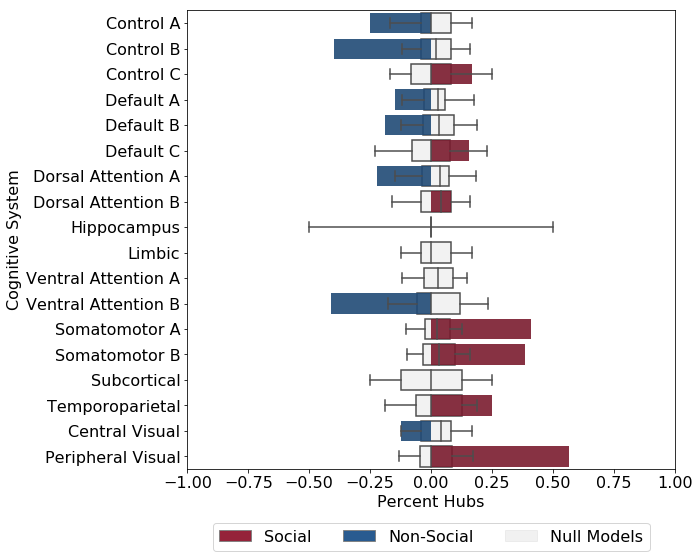

In [21]:
diff_null_df=pd.DataFrame(dict1['diff_null_percent'].T,columns=sys_labels)

pos_diff=df1['Soc_vs_NS_Percent'].values.copy()
neg_diff=df1['Soc_vs_NS_Percent'].values.copy()
pos_diff[pos_diff<0]=0
neg_diff[neg_diff>0]=0

fig, ax = plt.subplots(figsize=(10,8))
l1=sns.barplot(x='value',y='variable',
            data=pd.DataFrame(zip(pos_diff,sys_labels),columns=['value','variable']),
            color=custom_palette[1],ax=ax,alpha=0.9)
l2=sns.barplot(x='value',y='variable',
            data=pd.DataFrame(zip(neg_diff,sch_names),columns=['value','variable']),
            color=custom_palette[0],ax=ax,alpha=0.9)
l3=sns.boxplot(x='value',y='variable',data=pd.melt(diff_null_df),
            #whis=[5,95],fliersize=0,color='gray',ax=ax,boxprops=dict(alpha=.3))
            whis=[5,95],fliersize=0,color='gray',ax=ax)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.1))
    #patch.set_linewidth(0.1)
    #r, g, b, a = patch.get_edgecolor()
    #patch.set_edgecolor((r, g, b, .1))
plt.xlim(-1, 1)
#plt.legend([l1, l2],["Non-Social", "Social"])

from matplotlib.patches import Patch

# Shrink current axis by 20%
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(handles=legend_elements,loc='lower left', bbox_to_anchor=(1, 0.5))

legend_elements = [Patch(facecolor=custom_palette[1],edgecolor='gray',label='Social',alpha=0.9),
                  Patch(facecolor=custom_palette[0],edgecolor='gray',label='Non-Social',alpha=0.9),
                  Patch(facecolor='gray',edgecolor='gray',label='Null Models',alpha=0.1)]

ax.legend(handles=legend_elements, loc='upper center',bbox_to_anchor=(0.5, -0.1),ncol=3)
ax.set(xlabel='Percent Hubs', ylabel='Cognitive System')
plt.tight_layout()
plt.savefig('{}/fig3c.svg'.format(path_Figures))



# Figure 2D: System-Level Connectivity Matrix for Transition vs. Non-Transition Contrast

In [22]:
diff_cog_sys_zmat,diff_cog_sys_pmat=load_zscores('netLearn_diffData_zscores_groupavg_cogsys_connmat.npz',thresh=True,alpha=0.025)

comb_cog_sys_zmat,comb_cog_sys_pmat=load_zscores('netLearn_combData_zscores_groupavg_cogsys_connmat.npz',thresh=True,alpha=0.025)

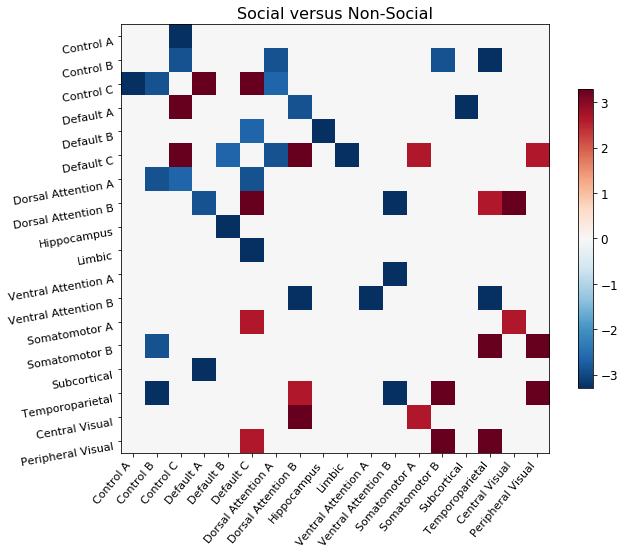

In [23]:
fig, ax1 = plt.subplots(figsize=(10,8))

display=plotting.plot_matrix(diff_cog_sys_zmat,vmin=-3.3,vmax=3.3,
                     labels=sys_labels,axes=ax1,colorbar=False,auto_fit=False)

plt.title('Social versus Non-Social')
cbar = plt.colorbar(display, ax = ax1, shrink = 0.7)
cbar.ax.tick_params(labelsize=12) 
plt.tight_layout()

plt.savefig('{}/fig3d.svg'.format(path_Figures))

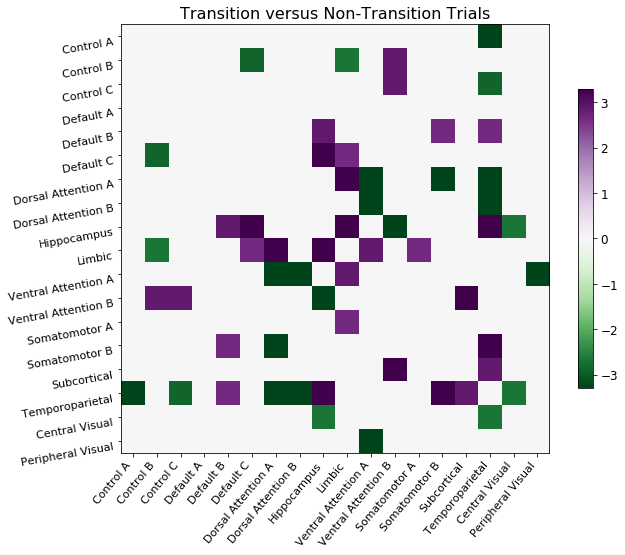

In [24]:
fig, ax1 = plt.subplots(figsize=(10,8))

display=plotting.plot_matrix(comb_cog_sys_zmat,vmin=-3.3,vmax=3.3,cmap='PRGn_r',
                     labels=sys_labels,axes=ax1,colorbar=False,auto_fit=False)
plt.title('Transition versus Non-Transition Trials')
cbar = plt.colorbar(display, ax = ax1, shrink = 0.7)
cbar.ax.tick_params(labelsize=12) 
plt.tight_layout()

plt.savefig('{}/fig2d.svg'.format(path_Figures))

plt.show()

# Figure 4A: Hub Connectivity Matrix for Social vs. Non-Social Contrast

In [25]:
def sub_dict_remove1(mydict, somekeys,default=None):
    somedict=mydict.copy()
    tdict=dict([ (k, somedict.pop(k, default)) for k in somekeys ])
    return tdict

def sub_dict_remove2(mydict, somekeys,default=None):
    somedict=mydict.copy()
    tdict=dict([ (k, somedict.pop(k, default)) for k in somekeys ])
    return dict((k, v) for k, v in tdict.iteritems() if v)

sigdic_rois={'ns_hub':sigdic_diff_ns.copy(),
             'soc_hub':sigdic_diff.copy(),
             'comb_hub':sigdic_comb.copy()}

for key in sigdic_rois:
    sigdic_rois[key]=sub_dict_remove2(sigdic_rois[key],roi_names)
    
syslist_rois={}
for k1 in sigdic_rois.keys():
    for k2 in sigdic_rois[k1].keys():
        syslist_rois['{}_{}'.format(k1,k2)]=sigdic_rois[k1][k2]
                
print('{} hubs in syslist_rois'.format(len(syslist_rois)))

keys1=[key for key in syslist_rois.keys() if 'soc' in key or 'ns' in key or 'Hippocampus_' in key]

syslist_rois2=sub_dict_remove2(syslist_rois,keys1)

syslist_rois2

14 hubs in syslist_rois


{'comb_hub_Hippocampus_L': [402],
 'comb_hub_Hippocampus_R': [407],
 'ns_hub_dmPFC_L': [165, 177],
 'ns_hub_dmPFC_R': [310, 370, 371, 376, 378],
 'ns_hub_lPFC_L': [182],
 'ns_hub_lPFC_R': [308, 332, 304],
 'soc_hub_TPJ_L': [85, 172],
 'soc_hub_TPJ_R': [262, 394, 396, 397]}

In [26]:
diff_roihub_zmat,diff_roihub_pmat=load_zscores('netLearn_diffData_zscores_groupavg_roihub_connmat.npz',thresh=True,alpha=0.025)

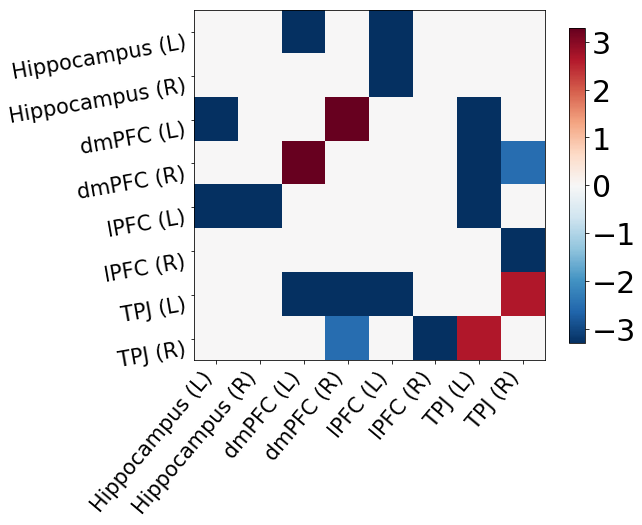

In [27]:
newlabs=['Hippocampus (L)','Hippocampus (R)',
         'dmPFC (L)','dmPFC (R)',
        'lPFC (L)','lPFC (R)',
        'TPJ (L)','TPJ (R)']

SMALL_SIZE = 30
MEDIUM_SIZE = 30
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax1 = plt.subplots(figsize=(10,8))
display=plotting.plot_matrix(diff_roihub_zmat,vmin=-3.3,vmax=3.3,labels=newlabs,axes=ax1,colorbar=False,auto_fit=False)

#plt.title('Social versus Non-Social')
#fig.subplots_adjust(wspace=0.5)
cbar = plt.colorbar(display, ax = ax1, shrink = 0.9)
#cbar.ax.tick_params(labelsize=12) 
plt.tight_layout()

plt.savefig('{}/fig4a.svg'.format(path_Figures))

# Figure 4B: Connectivity between hippocampus and other hubs for social versus non-social contrast

In [28]:
sch_coords=zip(schaefer_atlas.loc[:,'x'],schaefer_atlas.loc[:,'y'],schaefer_atlas.loc[:,'z'])

In [29]:
def load_zmat(task,namestr,roi,thresh=True,alpha=0.025):
    '''
    loads cfg (vectorized) connectivity matrix (both z-scores and p-values) and converts to n_node x n_node connectivity matrix

    Parameters
    ----------
        task: character string
            string indicating the task contrast
        namestr: character string
            string indicating additional info to include in filename
        roi: character string
            string indicating the roi or node strength metric
    
    Optional Inputs
    _______________
        thresh: boolean
            if thresh==True, then save the connectivity matrix as a png image
        alpha: float
            decimal indicating what p-value threshold to use
            
    Returns
    -------
        zMat: numpy array
            1D n_nodes numpy array of z-scores
            or 2D n_nodes x n_nodes numpy array of z-scores
    '''
    data=np.load(opj(path_zData,'netLearn_{}_{}_{}.npz'.format(task,namestr,roi)))
    zMat=data['zMat']
    pMat=data['pMat']
    #Convert the arbitrarily set values for p=0 (where z=inf or -inf) from 4 to 
    #a less arbitrary z=3.29 or z=-3.29
    #which should be greater than max value so long as len(null_dist)<2000
    zMat[zMat==4]=ss.norm.ppf(.9995)
    zMat[zMat==-4]=ss.norm.ppf(.0005)

    if thresh:
        reject_fdr,pval_fdr=fdr_correction(pMat,alpha)
        zMat=np.multiply(zMat,reject_fdr)
    return zMat

def sub_matrix(subjMat,ixes):
    '''
    Get subset of the matrix using identical indices for rows and columns

    Parameters
    ----------
        subjMat: numpy array
            2D matrix with n_node x n_node shape
            or
            3D matrix with n_subj x n_node x n_node shape
        ixes: list or numpy array
            list of integers indicating which rows and columns to keep
            
    Returns
    ________________
        newMat: numpy array
            2D matrix with len(ixes) x len(ixes) shape
            or
            3D matrix with n_subj x len(ixes) x len(ixes) shape
    '''
    if subjMat.ndim==3:
        newMat=subjMat[:,ixes,:]
        newMat=newMat[:,:,ixes]
    else:
        newMat=subjMat[ixes,:]
        newMat=newMat[:,ixes]        
    print('Shape of matrix is {}'.format(newMat.shape))
    return newMat



def plot_connectomes(mat_ix,df1,figTitle,net_coords,mat_cols=None,node_sizes=None,
                     figName=None,nodeMethod='All',nodeThresh=95,
                     eMethod='All',eThresh="95%",figtype='svg'):
    '''
    Add description of function here

    Parameters
    ----------
        need to add: format
            description
            
    Optional Inputs
    _______________
        need to add: format
            description
    
    Returns
    ________________
        need to add: format
            description
    '''
    df1=sub_matrix(df1,mat_ix)
    mat_coords=np.array(net_coords)[mat_ix]
    if mat_cols is None:
        mat_cols=np.array(['dimgray']*len(mat_ix))
    else:
        mat_cols=np.array(mat_cols)[mat_ix]
        
    if node_sizes is None:
        node_sizes=np.array([30]*len(mat_ix))
    else:
        node_sizes=np.array(node_sizes)[mat_ix]
    #df1=np.mean(medMat,axis=0)
    rowMeans=np.mean(df1,axis=1)
    rowCount=np.sum(df1!=0,axis=1)
    
    if nodeMethod=='All':
        sub_ixes=range(df1.shape[0])
    elif nodeMethod=='Count':
        sub_ixes=np.where(rowCount>np.percentile(rowCount,nodeThresh))[0]
    elif nodeMethod=='Mean':
        sub_ixes=np.where(rowMeans>np.percentile(rowMeans,nodeThresh))[0]
        
    #cv_edges=np.where(np.abs(df1)>.6,1,0)
    cv_edges=sub_matrix(df1,sub_ixes)
    cv_coords=mat_coords[sub_ixes]
    cv_colors=mat_cols[sub_ixes].tolist()
    cv_sizes=node_sizes[sub_ixes].tolist()
    
    if eMethod=='None':
        cv_edges=np.zeros(cv_edges.shape)
    plotting.plot_connectome(cv_edges, cv_coords, 
                             display_mode = 'lzry', 
                             annotate = False,
                             node_color= cv_colors,
                             node_size=cv_sizes,
                             edge_cmap='RdBu_r',
                             edge_threshold=eThresh,
                             edge_kwargs={'linewidth':1.5},node_kwargs={'linewidths':1,'edgecolor':'black'})
                             #title = figTitle);
    if figName:
        plt.savefig('{}/{}.{}'.format(path_Figures,figName,figtype))
    print('Mean effect size for displayed edges={}'.format(np.mean(cv_edges)))

def hipp_conn_plot(task,namestr,figtitle='',flip=False,valence='pos',roi_ix='all',savename=None):
    '''
    Add description of function here

    Parameters
    ----------
        need to add: format
            description
            
    Optional Inputs
    _______________
        need to add: format
            description
    
    Returns
    ________________
        need to add: format
            description
    '''
    conn_mat=np.zeros((n_node,n_node))
    
    hcolors=np.array(['dimgray']*n_node)
    hsizes=np.array([40]*n_node)
    for rr in ['Hippocampus_L','Hippocampus_R']:
        roi_zMat=load_zmat(task=task,namestr=namestr,roi=rr)
        col_ix=np.where(schaefer_atlas['ns_ROI_label']==rr)[0][0]
        conn_mat[:,col_ix]=np.expand_dims(roi_zMat,axis=0)
        conn_mat[col_ix,:]=np.expand_dims(roi_zMat,axis=0)   
        hcolors[col_ix]='gold'
        hsizes[col_ix]=90
    if flip:
        conn_mat=np.multiply(conn_mat,-1)
        
    if valence=='pos':
        pos_mat=conn_mat.copy()
        pos_mat[pos_mat<0]=0
        if roi_ix=='all':
            plot_connectomes(np.where(np.sum(pos_mat,axis=0)!=0)[0],pos_mat,figtitle,sch_coords,mat_cols=hcolors,node_sizes=hsizes,figName=savename)
        else:
            plot_connectomes(roi_ix,pos_mat,figtitle,sch_coords)
    elif valence=='neg':
        neg_mat=conn_mat.copy()
        neg_mat[neg_mat>0]=0
        if roi_ix=='all':
            plot_connectomes(np.where(np.sum(neg_mat,axis=0)!=0)[0],neg_mat,figtitle,sch_coords,mat_cols=hcolors,node_sizes=hsizes,figName=savename)
        else:
            plot_connectomes(roi_ix,neg_mat,figtitle,sch_coords)
            
hipp_conn_plot('diffData','zscores_combhubs','Social vs. Non-Social',savename='fig4b_pos')
hipp_conn_plot('diffData','zscores_combhubs','Non-Social vs. Social',valence='neg',savename='fig4b_neg')

IOError: [Errno 2] No such file or directory: '/Users/steventompson/Git/tompson_netlearn_fmri/data/ppi_zscores/netLearn_diffData_zscores_combhubs_Hippocampus_L.npz'

In [ ]:
def sub_matrix(subjMat,ixes):
    '''
    Get subset of the matrix using identical indices for rows and columns

    Parameters
    ----------
        subjMat: numpy array
            2D matrix with n_node x n_node shape
            or
            3D matrix with n_subj x n_node x n_node shape
        ixes: list or numpy array
            list of integers indicating which rows and columns to keep
            
    Returns
    ________________
        newMat: numpy array
            2D matrix with len(ixes) x len(ixes) shape
            or
            3D matrix with n_subj x len(ixes) x len(ixes) shape
    '''
    if subjMat.ndim==3:
        newMat=subjMat[:,ixes,:]
        newMat=newMat[:,:,ixes]
    else:
        newMat=subjMat[ixes,:]
        newMat=newMat[:,ixes]        
    print('Shape of matrix is {}'.format(newMat.shape))
    return newMat



def plot_connectomes(mat_ix,df1,figTitle,net_coords,mat_cols=None,node_sizes=None,
                     figName=None,nodeMethod='All',nodeThresh=95,
                     eMethod='All',eThresh="95%",figtype='svg'):
    '''
    Add description of function here

    Parameters
    ----------
        need to add: format
            description
            
    Optional Inputs
    _______________
        need to add: format
            description
    
    Returns
    ________________
        need to add: format
            description
    '''
    df1=sub_matrix(df1,mat_ix)
    mat_coords=np.array(net_coords)[mat_ix]
    if mat_cols is None:
        mat_cols=np.array(['dimgray']*len(mat_ix))
    else:
        mat_cols=np.array(mat_cols)[mat_ix]
        
    if node_sizes is None:
        node_sizes=np.array([30]*len(mat_ix))
    else:
        node_sizes=np.array(node_sizes)[mat_ix]
    #df1=np.mean(medMat,axis=0)
    rowMeans=np.mean(df1,axis=1)
    rowCount=np.sum(df1!=0,axis=1)
    
    if nodeMethod=='All':
        sub_ixes=range(df1.shape[0])
    elif nodeMethod=='Count':
        sub_ixes=np.where(rowCount>np.percentile(rowCount,nodeThresh))[0]
    elif nodeMethod=='Mean':
        sub_ixes=np.where(rowMeans>np.percentile(rowMeans,nodeThresh))[0]
        
    #cv_edges=np.where(np.abs(df1)>.6,1,0)
    cv_edges=sub_matrix(df1,sub_ixes)
    cv_coords=mat_coords[sub_ixes]
    cv_colors=mat_cols[sub_ixes].tolist()
    cv_sizes=node_sizes[sub_ixes].tolist()
    
    if eMethod=='None':
        cv_edges=np.zeros(cv_edges.shape)
    plotting.plot_connectome(cv_edges, cv_coords, 
                             display_mode = 'lzry', 
                             annotate = False,
                             node_color= cv_colors,
                             node_size=cv_sizes,
                             edge_cmap='RdBu_r',
                             edge_threshold=eThresh,
                             edge_kwargs={'linewidth':1.5},node_kwargs={'linewidths':1,'edgecolor':'black'})
                             #title = figTitle);
    if figName:
        plt.savefig('{}/{}.{}'.format(path_Figures,figName,figtype))
    print('Mean effect size for displayed edges={}'.format(np.mean(cv_edges)))

    
def thresh_func(zmat,pmat,alpha=0.025):
        reject_fdr,fdr_pvals=fdr_correction(pmat,alpha)
        zmat=np.multiply(zmat,reject_fdr)
        return zmat

def hipp_conn_plot(z_mat,p_mat,figtitle='',flip=False,valence='pos',roi_ix='all',savename=None):
    '''
    Add description of function here

    Parameters
    ----------
        need to add: format
            description
            
    Optional Inputs
    _______________
        need to add: format
            description
    
    Returns
    ________________
        need to add: format
            description
    '''
    conn_mat=np.zeros(z_mat.shape)
    
    hcolors=np.array(['dimgray']*n_node)
    hsizes=np.array([40]*n_node)
    for rr in ['Hippocampus_L','Hippocampus_R']:
        col_ix=np.where(schaefer_atlas['ns_ROI_label']==rr)[0][0]
        temp_zmat=z_mat[:,col_ix]
        temp_pmat=p_mat[:,col_ix]
        thr_zmat=thresh_func(temp_zmat,temp_pmat)
        conn_mat[:,col_ix]=thr_zmat
        conn_mat[col_ix,:]=thr_zmat 
        hcolors[col_ix]='gold'
        hsizes[col_ix]=90
    if flip:
        conn_mat=np.multiply(conn_mat,-1)
        
    if valence=='pos':
        pos_mat=conn_mat.copy()
        pos_mat[pos_mat<0]=0
        if roi_ix=='all':
            plot_connectomes(np.where(np.sum(pos_mat,axis=0)!=0)[0],pos_mat,figtitle,sch_coords,mat_cols=hcolors,node_sizes=hsizes,figName=savename)
        else:
            plot_connectomes(roi_ix,pos_mat,figtitle,sch_coords)
    elif valence=='neg':
        neg_mat=conn_mat.copy()
        neg_mat[neg_mat>0]=0
        if roi_ix=='all':
            plot_connectomes(np.where(np.sum(neg_mat,axis=0)!=0)[0],neg_mat,figtitle,sch_coords,mat_cols=hcolors,node_sizes=hsizes,figName=savename)
        else:
            plot_connectomes(roi_ix,neg_mat,figtitle,sch_coords)
            
hipp_conn_plot(diff_zMat_g,diff_pMat_g,'Social vs. Non-Social',savename='fig4b_pos')
hipp_conn_plot(diff_zMat_g,diff_pMat_g,'Non-Social vs. Social',valence='neg',savename='fig4b_neg')

# Supplementary Figures: Plot GLM Results

In [ ]:
glm_path=opj(data_dir,'supplement','netLearn_glm')

def plot_zmap(img_name,img_folder='',alpha=0.001,thresh=False,tmode='fdr',savename='',
              save=False,plot=False,effect='pos',dmode='ortho',ccoords=[-10,-10,10]):
    '''
    Add description of function here

    Parameters
    ----------
        need to add: format
            description
            
    Optional Inputs
    _______________
        need to add: format
            description
    
    Returns
    ________________
        need to add: format
            description
    '''

    #Load nii image
    mimg=nb.load(opj(glm_path,'secondLevel',img_name))
    if effect=='neg':
        mimg=image.math_img('img1*-1',img1=mimg)
        
    if thresh:
        new_img,thr=thresholding.map_threshold(stat_img=mimg,
                                               level=alpha,
                                               height_control=tmode,
                                               cluster_threshold=5)
    else:
        new_img=mimg
        
    if effect=='neg':
        new_img=image.math_img('img1*-1',img1=new_img)

    savefolder=opj(glm_path,'secondLevel','results_zmaps')
    if not os.path.exists(savefolder):
        os.makedirs(savefolder)
    
    savefile = '{}/{}_{}.nii.gz'.format(savefolder,savename,effect)
    nb.save(new_img,savefile)
    
    if plot:
        plotting.plot_stat_map(savefile,display_mode=dmode,cut_coords=ccoords,title=savename)
    
    return new_img

In [ ]:
pos_img1=plot_zmap(img_name='netLearn_interceptXtransition_secondLevel_zmap.nii.gz',
          img_folder='',alpha=0.05,thresh=True,tmode='fdr',
          dmode='x',ccoords=[-50,-25,-5,5,25,50],
          savename='transition_contrast_thresh',plot=False)

neg_img1=plot_zmap(img_name='netLearn_interceptXtransition_secondLevel_zmap.nii.gz',
          img_folder='',alpha=0.05,thresh=True,tmode='fdr',effect='neg',
          dmode='x',ccoords=[-50,-25,-5,5,25,50],
          savename='transition_contrast_thresh',plot=False)

cimg1=image.math_img('img1+img2',img1=pos_img1,img2=neg_img1)
d1=plotting.plot_stat_map(cimg1,display_mode='x',cut_coords=[-55,-50,-25,-10,-5],cmap='PRGn_r',vmax=4)
d2=plotting.plot_stat_map(cimg1,display_mode='x',cut_coords=[5,10,25,50,55],cmap='PRGn_r',vmax=4)
d1.savefig('{}/glm_transition_contrast_fig_lh.svg'.format(path_Figures))
d2.savefig('{}/glm_transition_contrast_fig_rh.svg'.format(path_Figures))

In [ ]:
pos_img2=plot_zmap(img_name='netLearn_condXtransition_secondLevel_zmap.nii.gz',
          img_folder='',alpha=0.05,thresh=True,tmode='fdr',
          dmode='x',ccoords=[-50,-25,-5,5,25,50],
          savename='condXtransition_contrast_thresh',plot=False)

neg_img2=plot_zmap(img_name='netLearn_condXtransition_secondLevel_zmap.nii.gz',
          img_folder='',alpha=0.05,thresh=True,tmode='fdr',effect='neg',
          dmode='x',ccoords=[-50,-25,-5,5,25,50],
          savename='condXtransition_contrast_thresh',plot=False)

cimg2=image.math_img('img1+img2',img1=pos_img2,img2=neg_img2)
d1=plotting.plot_stat_map(cimg2,display_mode='x',cut_coords=[-50,-25,-5])
d2=plotting.plot_stat_map(cimg2,display_mode='x',cut_coords=[5,25,50])
#d1.savefig('{}/{}_{}_lh.{}'.format(path_Figures,yy,xx,figtype))
#d2.savefig('{}/{}_{}_rh.{}'.format(path_Figures,yy,xx,figtype))

# Jaccard Similarity for hubs with neurosynth terms

In [32]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    #print(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    similarity = float(intersection / union)
    return intersection, union, similarity

def term_overlap(sigval_list,ns_term):
    tb=ns_term+'_bi'
    tixes=np.where(schaefer_atlas[tb]==1)[0]
    ii,uu,ss=jaccard_similarity(sigval_list,tixes)
    return ii,uu,ss



term_list=['social','mentalizing','memory','attention','perception',
           'reward','learning','motivation','emotion',
           'visual','workMem','visual_attention','visual_perception']


jac_ov_df=pd.DataFrame(index=term_list,columns=['DG Pos Intersection','DG Pos Union','DG Pos Overlap','DG Pos Percent',
                                                'DG Neg Intersection','DG Neg Union','DG Neg Overlap','DG Neg Percent',
                                                'Soc Intersection','Soc Union','Soc Overlap','Soc Percent',
                                                'NS Intersection','NS Union','NS Overlap','NS Percent'])
for term in term_list:
    trans_int,trans_union,trans_sim =  term_overlap(sigvals_comb_all,term)
    nontrans_int,nontrans_union,nontrans_sim =  term_overlap(sigvals_comb_neg_all,term)
    soc_int,soc_union,soc_sim =  term_overlap(sigvals_soc_all,term)
    ns_int,ns_union,ns_sim =  term_overlap(sigvals_ns_all,term)
    
    jac_ov_df.loc[term,'DG Pos Intersection'] = trans_int
    jac_ov_df.loc[term,'DG Pos Union'] = trans_union
    jac_ov_df.loc[term,'DG Pos Overlap'] = trans_sim
    jac_ov_df.loc[term,'DG Pos Percent'] = trans_int/len(sigvals_comb_all)
    
    jac_ov_df.loc[term,'DG Neg Intersection'] = nontrans_int
    jac_ov_df.loc[term,'DG Neg Union'] = nontrans_union
    jac_ov_df.loc[term,'DG Neg Overlap'] = nontrans_sim
    jac_ov_df.loc[term,'DG Neg Percent'] = nontrans_int/len(sigvals_comb_neg_all)
    
    jac_ov_df.loc[term,'Soc Intersection'] = soc_int
    jac_ov_df.loc[term,'Soc Union'] = soc_union
    jac_ov_df.loc[term,'Soc Overlap'] = soc_sim
    jac_ov_df.loc[term,'Soc Percent'] = soc_int/len(sigvals_soc_all)
    
    jac_ov_df.loc[term,'NS Intersection'] = ns_int
    jac_ov_df.loc[term,'NS Union'] = ns_union
    jac_ov_df.loc[term,'NS Overlap'] = ns_sim
    jac_ov_df.loc[term,'NS Percent'] = ns_int/len(sigvals_ns_all)
    
    print(term)
    print('     Transition hubs overlap =',round(trans_int/len(sigvals_comb_all),3)) 
    print('     Non-transition hubs overlap =',round(nontrans_int/len(sigvals_comb_neg_all),3)) 
    print('     Social hubs overlap =',round(soc_int/len(sigvals_soc_all),3))  
    print('     Non-social hubs overlap =',round(ns_int/len(sigvals_ns_all),3))
    print('')

social
     Transition hubs overlap = 0.139
     Non-transition hubs overlap = 0.041
     Social hubs overlap = 0.063
     Non-social hubs overlap = 0.091

mentalizing
     Transition hubs overlap = 0.083
     Non-transition hubs overlap = 0.102
     Social hubs overlap = 0.048
     Non-social hubs overlap = 0.036

memory
     Transition hubs overlap = 0.111
     Non-transition hubs overlap = 0.163
     Social hubs overlap = 0.048
     Non-social hubs overlap = 0.145

attention
     Transition hubs overlap = 0.0
     Non-transition hubs overlap = 0.041
     Social hubs overlap = 0.0
     Non-social hubs overlap = 0.055

perception
     Transition hubs overlap = 0.028
     Non-transition hubs overlap = 0.02
     Social hubs overlap = 0.048
     Non-social hubs overlap = 0.0

reward
     Transition hubs overlap = 0.028
     Non-transition hubs overlap = 0.0
     Social hubs overlap = 0.0
     Non-social hubs overlap = 0.073

learning
     Transition hubs overlap = 0.0
     Non-transition

In [39]:
jac_ov_df.loc[:,['DG Pos Intersection','DG Neg Intersection','Soc Intersection','NS Intersection']].sum()

DG Pos Intersection    14.0
DG Neg Intersection    45.0
Soc Intersection       24.0
NS Intersection        48.0
dtype: float64

In [44]:
jac_ov_df.loc[:,['DG Pos Intersection','DG Neg Intersection','Soc Intersection','NS Intersection',
                 'DG Pos Percent','DG Neg Percent','Soc Percent','NS Percent']]

,DG Pos Intersection,DG Neg Intersection,Soc Intersection,NS Intersection,DG Pos Percent,DG Neg Percent,Soc Percent,NS Percent
social,5,2,4,5,0.138889,0.0408163,0.0634921,0.0909091
mentalizing,3,5,3,2,0.0833333,0.102041,0.047619,0.0363636
memory,4,8,3,8,0.111111,0.163265,0.047619,0.145455
attention,0,2,0,3,0,0.0408163,0,0.0545455
perception,1,1,3,0,0.0277778,0.0204082,0.047619,0
reward,1,0,0,4,0.0277778,0,0,0.0727273
learning,0,0,0,0,0,0,0,0
motivation,0,0,0,0,0,0,0,0
emotion,0,0,0,2,0,0,0,0.0363636
visual,0,17,10,14,0,0.346939,0.15873,0.254545


In [15]:
sigdic_comb

{'Hippocampus': [402, 407],
 'Hippocampus_L': [402],
 'Hippocampus_R': [407],
 'TPJ_L': [44],
 'TPJ_R': [244],
 'combhubs': [44, 160, 165, 174, 244, 370, 376, 378, 402, 407],
 'dmPFC_L': [165, 174],
 'dmPFC_R': [370, 376, 378],
 'vmPFC_L': [160]}